In [84]:
import pickle

# Open and load the dictionary
with open("raw_data.pkl", "rb") as f:
    data = pickle.load(f)

# Access each variable
res = data["res"]
clu = data["clu"]
putative_type = data["putative_type"]
whl = data["whl"]
speed = data["speed"]
reward_arms = data["reward_arms"]
all_arms = data["all_arms"]
lwhl = data["lwhl"]
trials_segments_ms = data["trials_segments_ms"]
event_intervals_ms = data["event_intervals_ms"]
event_arm_ids = data["event_arm_ids"]
trial_ids_all= data["trial_ids_all"]
trial_ids_rewarded = data["trial_ids_rewarded"]

print("Data successfully loaded")

Data successfully loaded


In [2]:
import numpy as np
import pandas as pd

# Filter spikes by cell type (e.g., P1, B1, etc.)
def filter_cells_by_type(clu, putative_type, target_types=None):
    if target_types is None:
        return np.ones_like(clu, dtype=bool)
    
    target_types = [t.upper() for t in target_types]
    type_per_clu = putative_type["type"].str.upper().values
    clu_types = type_per_clu[clu]
    return np.isin(clu_types, target_types)

# Get neuron IDs (clu) by type
def get_cell_ids_by_type(putative_type, target_types):
    target_types = [t.upper() for t in target_types]
    type_per_clu = putative_type["type"].str.upper().values
    return np.where(np.isin(type_per_clu, target_types))[0]

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def binning_time(res, clu, putative_type, bin_size_ms, sampling_rate_neurons, sigma, cell_types=None, verify=False, verify_opts=None):
    """
    Bin spikes using fixed time windows.

    Returns
    -------
    spike_matrix : np.ndarray
        (n_cells_selected × n_bins), filtered by `cell_types` if provided.

    Notes
    -----
    - Setting `verify=True` shows:
      (1) a heatmap of a small time window (neurons × bins),
      (2) a bar plot of total spikes per neuron in that window.
    """
    from scipy.ndimage import gaussian_filter1d

    bin_size = int((bin_size_ms / 1000) * sampling_rate_neurons)  # fixed bug: use sampling_rate_neurons
    mask = filter_cells_by_type(clu, putative_type, cell_types)

    res_filt = res[mask]
    clu_filt = clu[mask]

    max_time = res_filt.max() if res_filt.size else 0
    n_bins = (max_time // bin_size) + 1 if bin_size > 0 else 0
    n_cells = len(putative_type)

    spike_matrix = np.zeros((n_cells, int(n_bins)), dtype=float)

    if res_filt.size:
        bin_indices = res_filt // bin_size
        for t, c in zip(bin_indices, clu_filt):
            spike_matrix[c, int(t)] += 1

    if cell_types is not None:
        active_cell_ids = get_cell_ids_by_type(putative_type, cell_types)
        spike_matrix = spike_matrix[active_cell_ids].astype(float)

    if sigma is not None and sigma > 0:
        spike_matrix = gaussian_filter1d(spike_matrix, sigma, axis=1)

    # verification plots (optional) 
    if verify:
        opts = verify_opts or {}
        # pick a window of bins to look at (default: first 100 bins or all if shorter)
        start = int(opts.get("start_bin", 0))
        width = int(opts.get("width_bins", min(100, spike_matrix.shape[1])))
        end = min(start + width, spike_matrix.shape[1])

        sub = spike_matrix[:, start:end]
        if sub.size > 0:
            plt.figure(figsize=(8, 4))
            plt.imshow(sub, aspect="auto", origin="lower")
            plt.title(f"Activity matrix window (neurons × bins) — bins {start}:{end}")
            plt.xlabel("Time bin"); plt.ylabel("Neuron")
            plt.tight_layout(); plt.show()

            totals = sub.sum(axis=1)
            plt.figure(figsize=(8, 3))
            plt.bar(np.arange(len(totals)), totals)
            plt.title("Total spikes per neuron in the shown window")
            plt.xlabel("Neuron"); plt.ylabel("Spike count")
            plt.tight_layout(); plt.show()

    return spike_matrix

In [7]:
def binning_n_spike(res, clu, putative_type, n_spikes_per_bin, cell_types=None, sigma=None, verify=False, verify_opts=None):
    """
    Bins spike data based on a fixed number of spikes per bin.

    Returns
    -------
    spike_matrix : np.ndarray
        (n_cells_selected × n_bins_spike).

    Notes
    -----
    - `verify=True` shows a small window heatmap + per-neuron totals for that window.
    """
    import numpy as np
    from scipy.ndimage import gaussian_filter1d

    if not isinstance(res, np.ndarray) or not isinstance(clu, np.ndarray):
        raise ValueError("res and clu must be NumPy arrays")
    if len(res) != len(clu):
        raise ValueError("res and clu must have the same length")
    if not isinstance(putative_type, pd.DataFrame) or "type" not in putative_type.columns:
        raise ValueError("putative_type must be a DataFrame with a 'type' column")
    if not isinstance(n_spikes_per_bin, int) or n_spikes_per_bin <= 0:
        raise ValueError("n_spikes_per_bin must be a positive integer")

    cluster_ids = np.arange(len(putative_type))
    if not np.all(np.isin(np.unique(clu), cluster_ids)):
        raise ValueError("clu contains cluster IDs not present in putative_type")

    mask = filter_cells_by_type(clu, putative_type, cell_types)
    res_filt = res[mask]
    clu_filt = clu[mask]

    if len(res_filt) == 0:
        raise ValueError("No spikes match the specified cell_types")

    total_spikes = len(res_filt)
    n_bins = total_spikes // n_spikes_per_bin
    n_cells = len(putative_type)

    spike_matrix = np.zeros((n_cells, max(n_bins, 1)), dtype=int)

    for i in range(n_bins):
        start = i * n_spikes_per_bin
        end = start + n_spikes_per_bin
        clu_bin = clu_filt[start:end]
        spike_matrix[:, i] = np.bincount(clu_bin, minlength=n_cells)

    remainder = total_spikes % n_spikes_per_bin
    if remainder > 0:
        clu_bin = clu_filt[n_bins * n_spikes_per_bin:]
        counts = np.bincount(clu_bin, minlength=n_cells)
        spike_matrix = np.hstack((spike_matrix, counts[:, np.newaxis]))

    if cell_types is not None:
        active_cell_ids = get_cell_ids_by_type(putative_type, cell_types)
        if len(active_cell_ids) == 0:
            raise ValueError("No cells match the specified cell_types")
        spike_matrix = spike_matrix[active_cell_ids]

    if sigma is not None:
        spike_matrix = spike_matrix.astype(float)
        spike_matrix = gaussian_filter1d(spike_matrix, sigma=sigma, axis=1)

    # verification plots (optional) 
    if verify:
        opts = verify_opts or {}
        start = int(opts.get("start_bin", 0))
        width = int(opts.get("width_bins", min(200, spike_matrix.shape[1])))
        end = min(start + width, spike_matrix.shape[1])

        sub = spike_matrix[:, start:end]
        if sub.size > 0:
            plt.figure(figsize=(8, 4))
            plt.imshow(sub, aspect="auto", origin="lower")
            plt.title(f"Spike-binned matrix window — bins {start}:{end}")
            plt.xlabel("Spike bin"); plt.ylabel("Neuron")
            plt.tight_layout(); plt.show()

            totals = sub.sum(axis=1)
            plt.figure(figsize=(8, 3))
            plt.bar(np.arange(len(totals)), totals)
            plt.title("Total counts per neuron in the shown spike-bin window")
            plt.xlabel("Neuron"); plt.ylabel("Count")
            plt.tight_layout(); plt.show()

    return spike_matrix

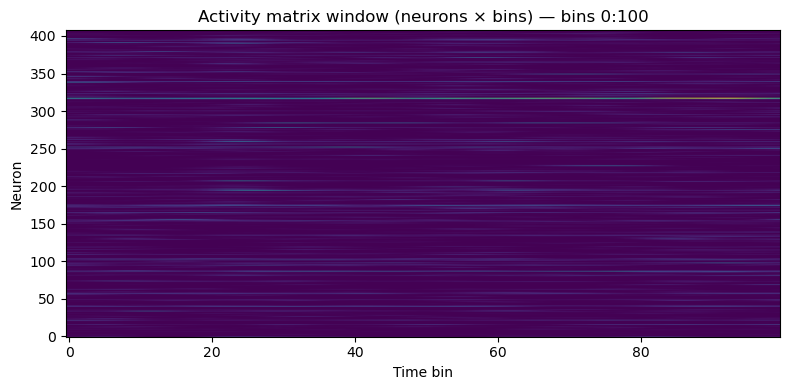

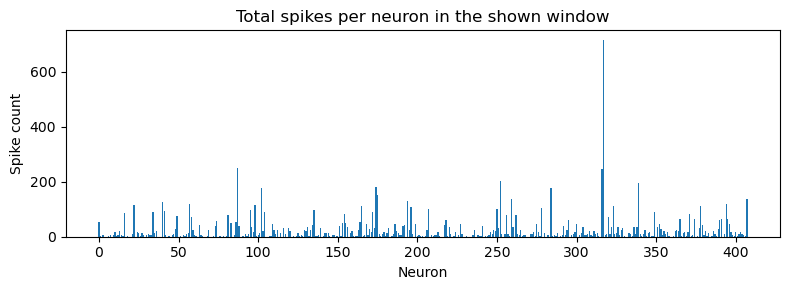

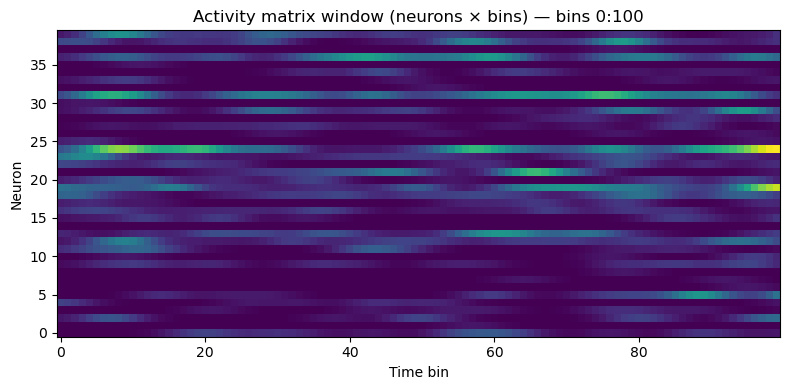

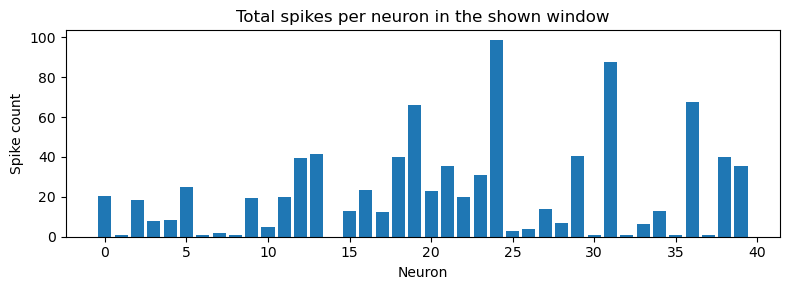

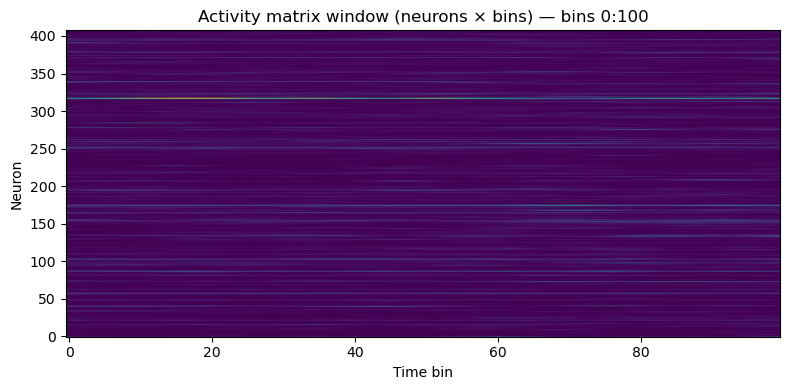

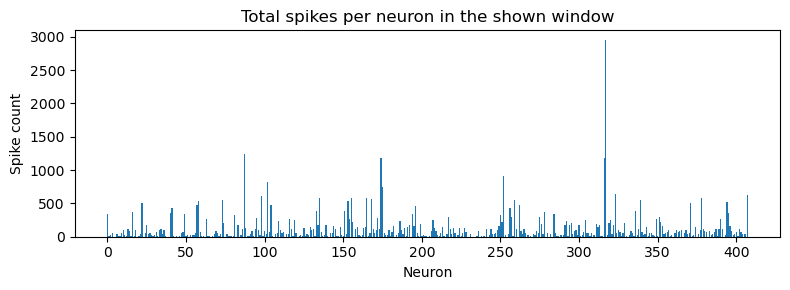

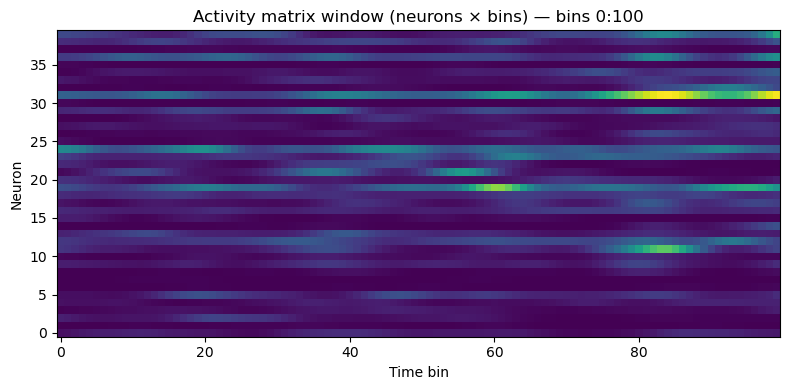

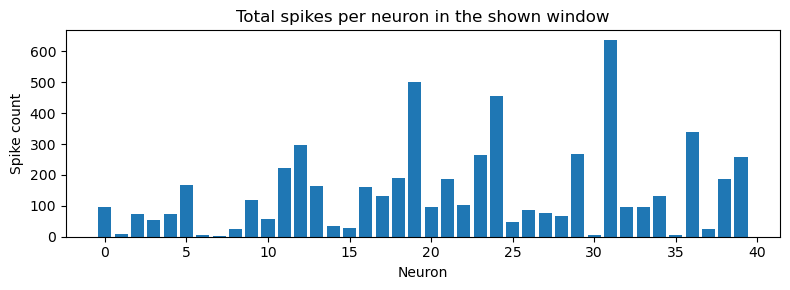

In [8]:
sampling_rate_neurons = 20000
sigma = 3

spike_mat_time_100pp = binning_time(res, clu, putative_type, 100, sampling_rate_neurons, sigma, ['pp'], verify=True, verify_opts=None)
spike_mat_time_100hp = binning_time(res, clu, putative_type, 100, sampling_rate_neurons, sigma, ['p1'], verify=True, verify_opts=None)
spike_mat_time_500pp = binning_time(res, clu, putative_type, 500, sampling_rate_neurons, sigma, ['pp'], verify=True, verify_opts=None)
spike_mat_time_500hp = binning_time(res, clu, putative_type, 500, sampling_rate_neurons, sigma, ['p1'], verify=True, verify_opts=None)

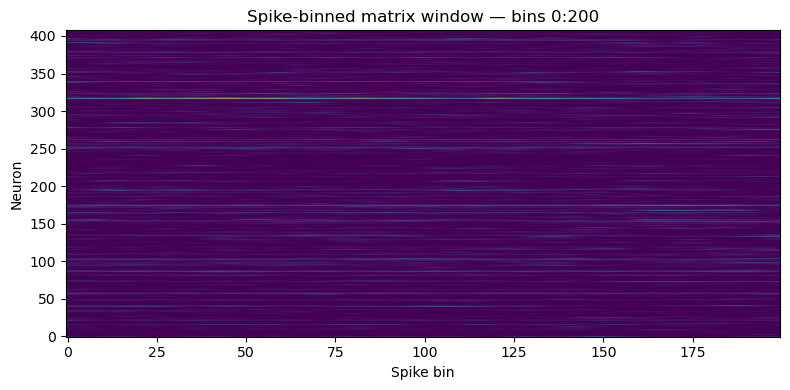

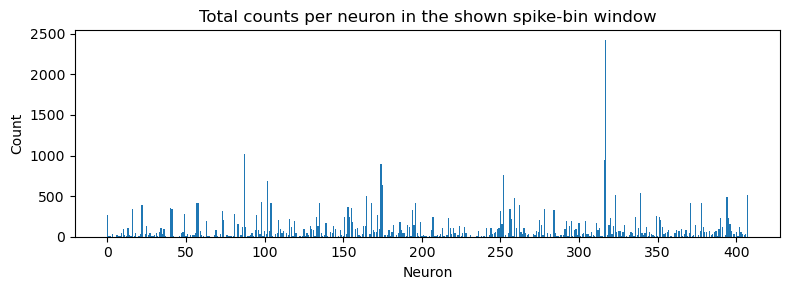

In [9]:
n_spikes_per_bin = 200
spike_mat_nspk_200pp = binning_n_spike(res, clu, putative_type, n_spikes_per_bin, ['pp'], sigma=3, verify=True, verify_opts=None)

In [10]:
import numpy as np
from typing import Optional, Tuple, Sequence

def filter_neural_by_speed_samples(
    neural_mat: np.ndarray,                 # shape = (n_neurons, n_bins)
    bin_size_ms: float,                     # duration of each neural bin in milliseconds
    speed: Sequence[float] | np.ndarray,    # 1-D speed vector, sampled at speed_hz
    speed_threshold: float,                 # keep bins with mean speed >= this
    *,
    speed_hz: float = 39.0625,              # sampling rate of the speed vector
    start_at_sample: int = 0,               # which speed sample corresponds to neural bin 0
    treat_empty_as_below: bool = True,      # bins with zero speed samples fail the threshold
    min_samples_per_bin: int = 0,           # require at least K samples; else treat as below
    return_mask_and_means: bool = True,     # also return (mask, per-bin means)
) -> Tuple[np.ndarray, Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Filter a neural matrix (neurons × time_bins) by average speed within each bin,
    when speed is given as a plain vector sampled at `speed_hz`.

    Timeline assumptions
    --------------------
    - Speed sample `speed[i]` corresponds to time t = i / speed_hz seconds.
    - Neural bin #0 starts at the speed *sample* `start_at_sample`.
      (Set start_at_sample=0 if bin 0 starts at the same time as speed[0].)

    Implementation
    --------------
    - Build integer sample edges for each neural bin using half-open intervals [L, R).
    - Use a cumulative sum over the speed vector to compute per-bin sums/means fast.
    - Keep bins where mean_speed >= speed_threshold and (#samples >= min_samples_per_bin).

    Returns
    -------
    neural_kept : (n_neurons, n_kept_bins) filtered matrix
    keep_mask   : (n_bins,) boolean mask of kept bins (if requested)
    mean_speed  : (n_bins,) per-bin mean speed (NaN if zero samples)
    """
    if neural_mat.ndim != 2:
        raise ValueError("`neural_mat` must be 2D (neurons × time_bins).")
    speed = np.asarray(speed, dtype=float)
    n_neurons, n_bins = neural_mat.shape
    if n_bins == 0:
        empty_bool = np.array([], dtype=bool)
        empty_float = np.array([], dtype=float)
        return neural_mat.copy(), (empty_bool if return_mask_and_means else None), (empty_float if return_mask_and_means else None)

    # Build sample-edge array for neural bins (half-open [L, R))
    # Convert bin_size_ms to *samples per bin* at speed_hz
    samples_per_ms = speed_hz / 1000.0
    # Edges in *samples* relative to the chosen start_at_sample
    # Use floor to ensure non-decreasing integer edges; some bins may have 0 samples if bins are very short.
    edges = start_at_sample + np.floor(np.arange(n_bins + 1, dtype=float) * bin_size_ms * samples_per_ms + 1e-9).astype(int)
    # Clip to [0, len(speed)]
    edges = np.clip(edges, 0, speed.shape[0])

    # Fast per-bin mean via cumulative sum 
    # cumsum trick: sum(L..R-1) = c[R] - c[L]
    c = np.concatenate(([0.0], np.cumsum(speed, dtype=float)))  # length = len(speed)+1
    # For each bin i: L=edges[i], R=edges[i+1]
    L = edges[:-1]
    R = edges[1:]
    counts = R - L
    sums = c[R] - c[L]
    # Avoid divide-by-zero; mark empty bins as NaN means
    mean_speed = np.full(n_bins, np.nan, dtype=float)
    nonempty = counts > 0
    mean_speed[nonempty] = sums[nonempty] / counts[nonempty]

    # Build keep mask 
    keep_mask = np.zeros(n_bins, dtype=bool)
    if treat_empty_as_below:
        valid = nonempty & (counts >= max(1, int(min_samples_per_bin)))
        keep_mask[valid] = mean_speed[valid] >= speed_threshold
    else:
        # If not treating empties as below, they still won't be kept unless they meet threshold
        valid = (counts >= max(1, int(min_samples_per_bin)))
        # mean_speed is NaN for empty bins; comparison yields False, which is fine.
        keep_mask[valid] = mean_speed[valid] >= speed_threshold

    # Filter neural matrix columns
    neural_kept = neural_mat[:, keep_mask]

    if return_mask_and_means:
        return neural_kept, keep_mask, mean_speed
    else:
        return neural_kept, None, None

In [14]:
# neural_mat: shape (n_neurons, n_bins)
# speed_vec:  shape (N_speed_samples,) at 39.0625 Hz (or your actual Hz)

spike_mat_time_100pp_speedfiltered, keep_mask, mean_speed = filter_neural_by_speed_samples(neural_mat=spike_mat_time_100pp,
    bin_size_ms=100.0,                  # neural time bin width of the spike matrix
    speed=speed,                   # plain 1-D vector of speeds
    speed_threshold=5,               # keep bins with mean speed >= 5 (for ex.)
    speed_hz=39.0625,                  # wheel sampling rate
    start_at_sample=0,                 # bin 0 aligns with speed[0]; change if needed
    treat_empty_as_below=True,         # empty bins are considered "not moving"
    min_samples_per_bin=0              # set >0 if you require e.g. at least 1–2 samples/bin
)

In [15]:
import numpy as np

def filter_low_spike_neurons(activity_matrix, min_spikes=100):
    """
    Filters neurons with less than `min_spikes` spikes in total over time.

    Parameters:
    - activity_matrix: np.ndarray of shape (n_neurons, n_time_bins)
        Matrix of neuronal activity (spike counts already binned).
    - min_spikes: int
        Treshold of minmum number of spikes per neuron across all events.

    Returns:
    - filtered_matrix: np.ndarray of shape (n_neurons_filtered, n_time_bins)
        Only neurons that passed the filter.
    - kept_indices: list of indexs of kept neurons
    """
    spike_sums = np.sum(activity_matrix, axis=1)
    kept_mask = spike_sums >= min_spikes
    filtered_matrix = activity_matrix[kept_mask, :]
    kept_indices = np.where(kept_mask)[0].tolist()
    
    print(f"Kept {filtered_matrix.shape[0]} / {activity_matrix.shape[0]} neurons (min {min_spikes} spikes)")
    return filtered_matrix, kept_indices

In [58]:
mat_100pp_filtered, neuron_indices = filter_low_spike_neurons(spike_mat_time_100pp_speedfiltered, min_spikes=100)

mat_100pp_spikefiltered, neuron_indices = filter_low_spike_neurons(spike_mat_time_100pp, min_spikes=100)
mat_500pp_spikefiltered, neuron_indices = filter_low_spike_neurons(spike_mat_time_500pp, min_spikes=100)
mat_100hp_spikefiltered, neuron_indices = filter_low_spike_neurons(spike_mat_time_100hp, min_spikes=100)
mat_500hp_spikefiltered, neuron_indices = filter_low_spike_neurons(spike_mat_time_500hp, min_spikes=100)

Kept 381 / 408 neurons (min 100 spikes)
Kept 399 / 408 neurons (min 100 spikes)
Kept 399 / 408 neurons (min 100 spikes)
Kept 40 / 40 neurons (min 100 spikes)
Kept 40 / 40 neurons (min 100 spikes)


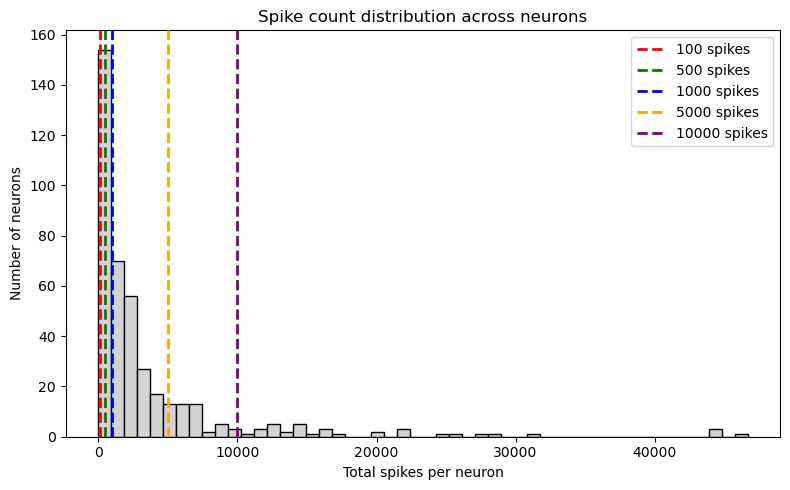

Neurons with ≥ 100 spikes: 381 / 408
Neurons with ≥ 500 spikes: 318 / 408
Neurons with ≥ 1000 spikes: 251 / 408
Neurons with ≥ 5000 spikes: 77 / 408
Neurons with ≥ 10000 spikes: 37 / 408


In [80]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spike_distribution(activity_matrix, thresholds=[100, 500, 1000, 5000, 10000]):
    """
    Plot the spike-count distribution across neurons and draw vertical lines
    for the provided thresholds. Each threshold line uses a different color.

    Parameters
    ----------
    activity_matrix : array-like, shape (n_neurons, n_timebins)
        Spike counts (or rates) per neuron over time bins.
    thresholds : list of numbers
        Thresholds (in total spikes) to mark with vertical lines.
    """
    # Sum spikes per neuron
    total_spikes = np.sum(activity_matrix, axis=1)

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(total_spikes, bins=50, color='lightgray', edgecolor='black')

    # Color palette: cycles if there are more thresholds than colors
    palette = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan', 'magenta', 'olive', 'teal']

    # Draw one colored line per threshold
    for i, t in enumerate(thresholds):
        color = palette[i % len(palette)]
        plt.axvline(t, color=color, linestyle='--', linewidth=2, label=f'{t} spikes', zorder=3)

    # Labels/legend
    plt.xlabel("Total spikes per neuron")
    plt.ylabel("Number of neurons")
    plt.title("Spike count distribution across neurons")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Report how many neurons pass each threshold
    for t in thresholds:
        n_passing = np.sum(total_spikes >= t)
        print(f"Neurons with ≥ {t} spikes: {n_passing} / {len(total_spikes)}")


plot_spike_distribution(spike_mat_time_100pp_speedfiltered)

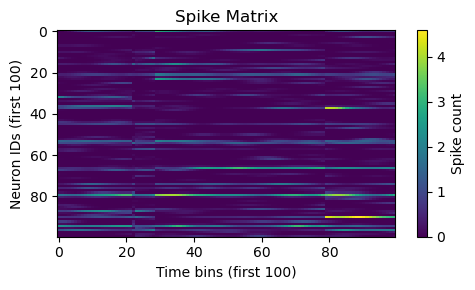

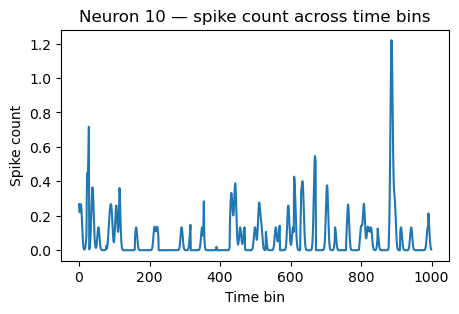

In [79]:
def plot_spike_matrix(activity_matrix, title="Spike Matrix", xlabel="Time bins (first 100)", ylabel="Neuron IDs (first 100)"):
    import matplotlib.pyplot as plt

    n_cells_to_plot = 100
    n_bins_to_plot = 100
    
    spike_view = activity_matrix[:n_cells_to_plot, :n_bins_to_plot]

    plt.figure(figsize=(5, 3))
    plt.imshow(spike_view, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Spike count")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 3))
    plt.plot(activity_matrix[10, :1000])
    plt.title("Neuron 10 — spike count across time bins")
    plt.xlabel("Time bin")
    plt.ylabel("Spike count")
    plt.show()

plot_spike_matrix(mat_100pp_filtered)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable, List, Tuple, Optional

def build_tensor_time_binning(
    activity_matrix_timebinned: np.ndarray,   # (n_neurons, total_bins) spike matrix NOT speed or spike filtered
    events_ms: Iterable[Tuple[float, float]], # [(start_ms, end_ms), ...]
    bin_size_ms: float,                       # ms per neural bin
    arm_ids: Iterable[int],                   # one per event
    *,
    # in-function speed filtering (keeps alignment)
    speed: Optional[np.ndarray] = None,       # 1-D wheel speed @ ~30.0625 Hz (index = sample #)
    speed_threshold: Optional[float] = None,  # keep bins whose mean speed >= threshold
    min_speed_samples_per_bin: int = 1,       # require ≥ this many speed samples in a bin
    # optional neuron filtering
    min_spikes: Optional[float] = None,       # drop neurons with total spikes < min_spikes
    # diagnostics / plots
    verify: bool = False, verify_opts: Optional[dict] = None,) -> Tuple[np.ndarray, List[int]]:
    """
    Build a 3D tensor [neurons × fixed_timebins × events] with no time warping:
      - Slice the neural matrix per event using bin edges.
      - (Optional) Within each event, drop neural bins whose mean wheel speed < threshold.
      - Choose fixed length = median (#bins after speed-filter) across events.
      - Truncate longer events, zero-pad shorter ones; stack into a tensor.

    Extra verification plots (verify=True):
      (A) Scatter of per-event mean activity for a chosen neuron (colored by arm).
      (B) Bar chart: per-arm mean±SEM activity of a *random* neuron.
      (C) Heatmaps of a couple of tensor *event slices* (neurons × fixed bins).

    Notes
    -----
    - No outlier rejection, no time warping.
    - Events partly outside range contribute overlapping bins; fully outside become zeros.
    - Neuron filter (min_spikes) is computed on the post-speed-filter per-event slices, before truncation/padding.
    """
    # --------- constants ---------
    SPEED_HZ = 39.0625  # wheel sample rate (adjust here if needed)

    # --------- inputs & prep ---------
    X = np.asarray(activity_matrix_timebinned, dtype=float)
    n_neurons, total_bins = X.shape

    events_ms = np.asarray(events_ms, dtype=float)
    arms = np.asarray(arm_ids, dtype=int)
    if events_ms.ndim != 2 or events_ms.shape[1] != 2:
        raise ValueError("`events_ms` must be (n_events, 2) with [start_ms, end_ms].")
    if len(events_ms) != len(arms):
        raise ValueError("`events_ms` and `arm_ids` must have the same length.")

    use_speed = (speed is not None) and (speed_threshold is not None)
    if use_speed:
        speed = np.asarray(speed, dtype=float)
        if speed.ndim != 1:
            raise ValueError("`speed` must be a 1-D vector.")
        n_speed = speed.shape[0]
        cs = np.concatenate(([0.0], np.cumsum(speed, dtype=float)))  # for fast interval sums

        def mean_speed_over(t0_ms: float, t1_ms: float) -> tuple[float, int]:
            """Mean wheel speed over [t0_ms, t1_ms) using half-open bounds."""
            L = int(np.floor((t0_ms / 1000.0) * SPEED_HZ))
            R = int(np.floor((t1_ms / 1000.0) * SPEED_HZ))
            if R <= L:
                R = L + 1
            L = max(0, min(n_speed, L))
            R = max(0, min(n_speed, R))
            cnt = R - L
            if cnt <= 0:
                return (np.nan, 0)
            return ( (cs[R] - cs[L]) / cnt, cnt )
    else:
        cs = None  # noqa

    # --------- 1) slice neural by event (and optional speed-filter per bin) ---------
    event_slices: List[np.ndarray] = []   # each (neurons, bins_after_speed)
    kept_arms: List[int] = []
    post_lengths: List[int] = []

    # for neuron filter: accumulate total spikes on post-speed slices
    total_spikes_all_events = np.zeros(n_neurons, dtype=float)

    for (start_ms, end_ms), arm in zip(events_ms, arms):
        s_bin = int(np.floor(start_ms / bin_size_ms))
        e_bin = int(np.ceil (end_ms   / bin_size_ms))
        s_bin = max(0, min(total_bins, s_bin))
        e_bin = max(s_bin + 1, min(total_bins, e_bin))

        event_X = X[:, s_bin:e_bin]                 # (neurons, n_bins_i)
        n_bins_i = event_X.shape[1]

        if use_speed and n_bins_i > 0:
            # time edges in ms for each neural bin
            g = np.arange(s_bin, e_bin, dtype=int)
            t0_ms = g * float(bin_size_ms)
            t1_ms = t0_ms + float(bin_size_ms)

            means = np.empty(n_bins_i, dtype=float)
            cnts  = np.empty(n_bins_i, dtype=int)
            for j in range(n_bins_i):
                means[j], cnts[j] = mean_speed_over(t0_ms[j], t1_ms[j])

            valid = (cnts >= int(min_speed_samples_per_bin)) & np.isfinite(means) & (means >= float(speed_threshold))
            event_X = event_X[:, valid] if valid.any() else event_X[:, :0]

        if event_X.size:
            total_spikes_all_events += np.nansum(event_X, axis=1)

        event_slices.append(event_X)
        kept_arms.append(int(arm))
        post_lengths.append(int(event_X.shape[1]))

    if len(post_lengths) == 0:
        return np.zeros((n_neurons, 1, 0), dtype=float), []

    # --------- 2) fixed length = median #bins after speed filter ---------
    fixed_n_bins = int(max(1, np.median(post_lengths)))

    # --------- 3) truncate/pad and stack ---------
    tensor_list: List[np.ndarray] = []
    for ev_X in event_slices:
        fixed = np.zeros((n_neurons, fixed_n_bins), dtype=ev_X.dtype)
        avail = ev_X.shape[1]
        if avail >= fixed_n_bins:
            fixed[:, :] = ev_X[:, :fixed_n_bins]
        elif avail > 0:
            fixed[:, :avail] = ev_X
        tensor_list.append(fixed)

    tensor = np.stack(tensor_list, axis=-1)  # (neurons, fixed_bins, n_events)

    # --------- 4) optional neuron filtering (by total spikes across events) ---------
    if min_spikes is not None:
        keep_neu = total_spikes_all_events >= float(min_spikes)
        if keep_neu.any():
            tensor = tensor[keep_neu, :, :]
        else:
            print(f"[filter] All neurons dropped by min_spikes={min_spikes}.")
            tensor = np.zeros((0, fixed_n_bins, tensor.shape[-1]), dtype=tensor.dtype)

    # --------- 5) verification / plots ---------
    if verify and tensor.shape[-1] > 0 and tensor.shape[0] > 0:
        opts = verify_opts or {}
        rng = np.random.default_rng(int(opts.get("random_state", 0)))

        # helper: colors by arm
        y = np.asarray(kept_arms, dtype=int)
        uniq_arms = np.unique(y)
        cmap = plt.colormaps["tab10"]
        arm2color = {a: cmap(i % 10) for i, a in enumerate(uniq_arms)}
        colors = np.array([arm2color[a] for a in y])

        print(f"[verify] events={tensor.shape[-1]} | fixed_n_bins={fixed_n_bins} "
              f"| post-filter median len={int(np.median(post_lengths))} "
              f"| speed_filter={'on' if use_speed else 'off'}")

        # pick neuron for plots
        neuron_idx = opts.get("neuron_idx", "auto")
        if neuron_idx == "auto" or not isinstance(neuron_idx, int) or neuron_idx < 0 or neuron_idx >= tensor.shape[0]:
            # random neuron among kept ones
            neuron_idx = int(rng.integers(0, tensor.shape[0]))
        print(f"[verify] plotting neuron index: {neuron_idx}")

        # (A) Scatter: per-event mean activity for chosen neuron, colored by arm
        # media por evento SIN padding (spikes/bin)
        per_event = np.array([
            np.nan if ev.shape[1] == 0 else np.nanmean(ev[neuron_idx])]) if False else np.array([
            (np.nan if ev.shape[1] == 0 else float(np.nanmean(ev[neuron_idx]))) for ev in event_slices])
        
        event_labels = np.arange(per_event.size)

        plt.figure(figsize=(7, 3.6))
        plt.scatter(event_labels, per_event, c=colors, s=18)
        plt.title(f"(A) Per-event mean — Neuron {neuron_idx}")
        plt.xlabel("Event"); plt.ylabel("Mean activity (spikes/bin)")
        plt.tight_layout(); plt.show()

        # (B) Bar: per-arm mean±SEM activity for a random neuron
        # (mean firing rate over time, then average across events of the same arm)
        def _sem_safe(v: np.ndarray) -> float:
            """
            SEM robust to small samples and NaNs.
            - If n_valid == 0 -> return 0.0 (no barra de error).
            - If n_valid == 1 -> return 0.0 (sin warning por ddof).
            - If n_valid >= 2 -> std(ddof=1)/sqrt(n).
            """
            v = np.asarray(v, dtype=float)
            v = v[np.isfinite(v)]
            n = v.size
            if n <= 1:
                return 0.0
            return float(np.nanstd(v, ddof=1) / np.sqrt(n))
        
        # Make sure labels have the same dtype as uniq_arms (ints vs strs)
        labels_per_event = np.asarray(event_labels)
        try:
            uniq_cast   = np.array([int(a) for a in uniq_arms])
            labels_cast = labels_per_event.astype(int)
            color_key   = int
        except Exception:
            uniq_cast   = np.array([str(a) for a in uniq_arms])
            labels_cast = labels_per_event.astype(str)
            color_key   = str
        
        # Group by arm and compute mean±SEM
        means, sems, labels, bar_colors = [], [], [], []
        for a in uniq_cast:
            vals = per_event[labels_cast == a]
            # Si todos son NaN o no hay eventos, devolvemos mean=NaN y sem=0 para no dibujar barra de error
            m = np.nanmean(vals) if vals.size and np.isfinite(vals).any() else np.nan
            s = _sem_safe(vals) if vals.size else 0.0
            means.append(m)
            sems.append(s)
            labels.append(str(a))
            bar_colors.append(arm2color.get(color_key(a), "#999999"))
        
        means = np.asarray(means, dtype=float)
        sems  = np.asarray(sems,  dtype=float)
                
        # Plot
        means_to_plot = np.where(np.isfinite(means), means, 0.0)

        plt.figure(figsize=(6.5, 3.6))
        x = np.arange(len(labels))

        plt.bar(x, means_to_plot, yerr=sems, capsize=3,
            color=bar_colors, edgecolor='black',
            ecolor='black', error_kw={'elinewidth': 1.2})
        
        plt.xticks(x, labels)
        plt.title("(B) Per-arm mean (spikes/bin)")
        plt.xlabel("Arm ID"); plt.ylabel("Mean per-event value")
        plt.tight_layout(); plt.show()

        # (C) Heatmaps: a couple of event slices (neurons × fixed bins)
        # choose example events
        example_idx = opts.get("example_event_indices", None)
        if example_idx is None:
            n_show = int(opts.get("n_example_events", 2))
            n_show = max(1, min(n_show, tensor.shape[-1]))
            example_idx = rng.choice(tensor.shape[-1], size=n_show, replace=False)
        else:
            example_idx = np.atleast_1d(example_idx).astype(int)
            example_idx = example_idx[(example_idx >= 0) & (example_idx < tensor.shape[-1])]
            if example_idx.size == 0:
                example_idx = np.array([0], dtype=int)

        n_show = example_idx.size
        fig, axes = plt.subplots(1, n_show, figsize=(5*n_show, 4), dpi=110, squeeze=False)
        axes = axes.ravel()
        for ax, ev in zip(axes, example_idx):
            im = ax.imshow(tensor[:, :, ev], aspect='auto', origin='lower',
                           interpolation='nearest')
            ax.set_title(f"(C) Event {ev} — Arm {y[ev]}")
            ax.set_xlabel("Fixed bins"); ax.set_ylabel("Neurons")
            plt.colorbar(im, ax=ax, shrink=0.9, label="Activity (spikes/bin)")
        plt.tight_layout(); plt.show()

    return tensor, kept_arms

[verify] events=180 | fixed_n_bins=64 | post-filter median len=64 | speed_filter=on
[verify] plotting neuron index: 317


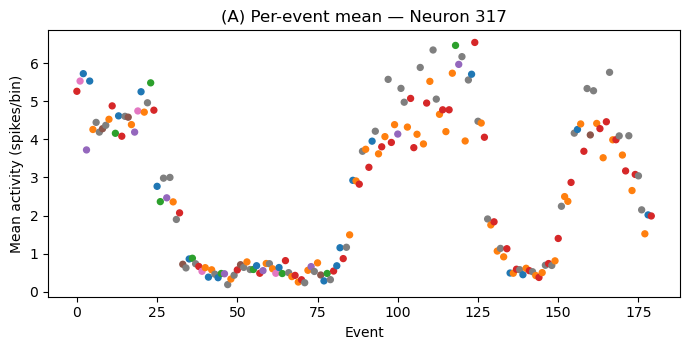

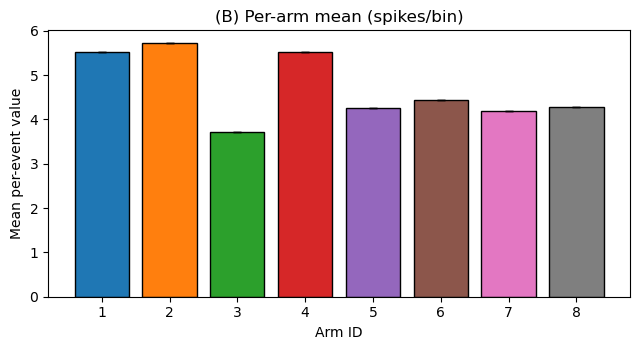

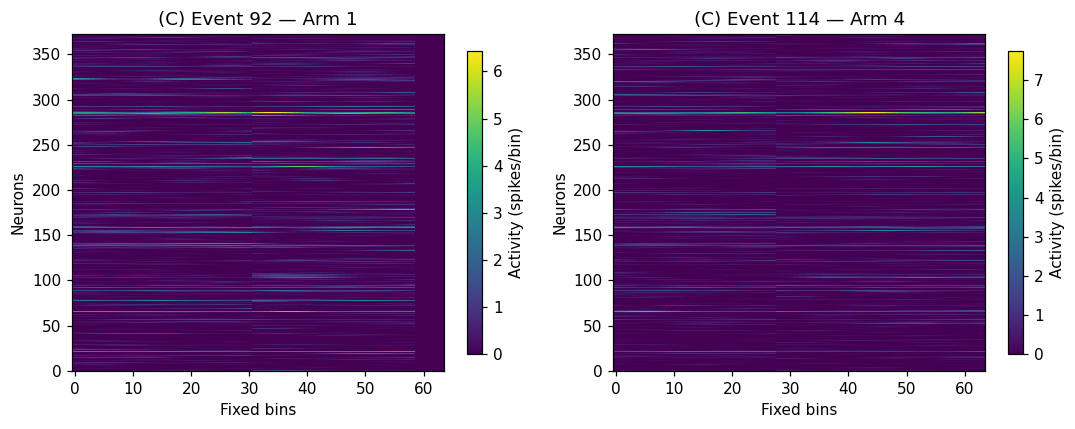

[verify] events=180 | fixed_n_bins=64 | post-filter median len=64 | speed_filter=on
[verify] plotting neuron index: 34


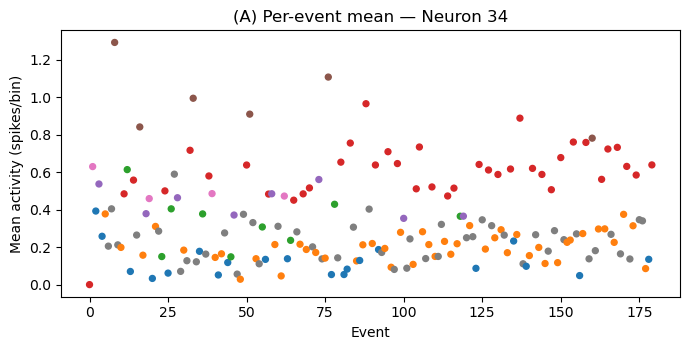

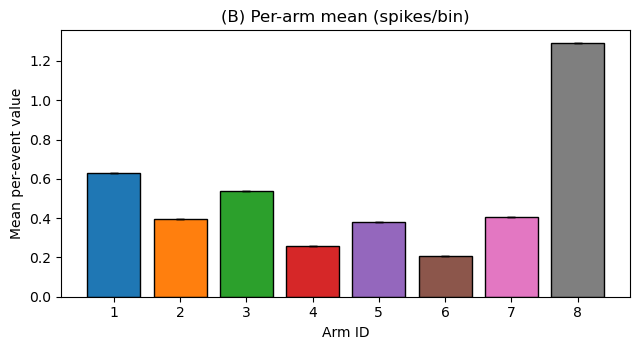

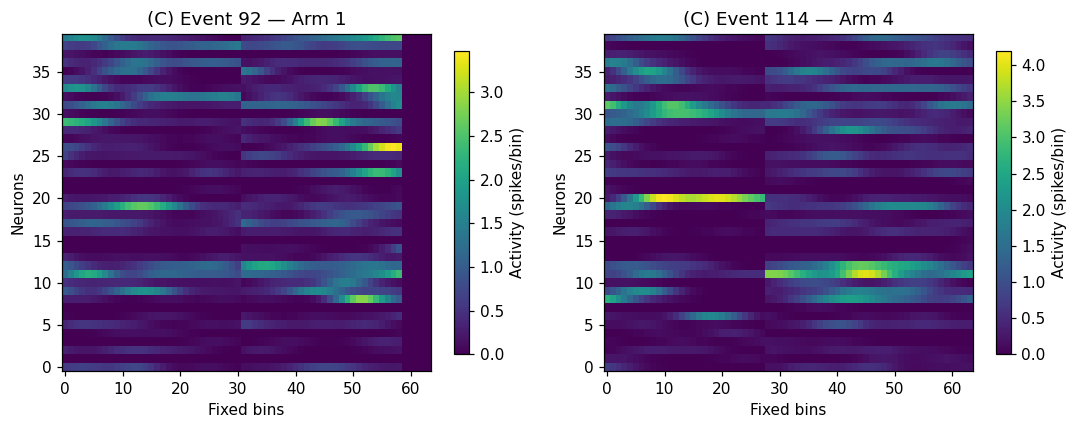

In [44]:
# With neuron filter (e.g., keep neurons with at least 100 spikes total across all events) after speed filter
tensorTE_filt_100pp, kept_arms = build_tensor_time_binning(spike_mat_time_100pp, event_intervals_ms, 100.0, event_arm_ids, speed=speed, speed_threshold=5, min_spikes=100, verify=True)
tensorTE_filt_100hp, kept_arms = build_tensor_time_binning(spike_mat_time_100hp, event_intervals_ms, 100.0, event_arm_ids, speed=speed, speed_threshold=5, min_spikes=100, verify=True)
tensorTE_filt_500pp, kept_arms = build_tensor_time_binning(spike_mat_time_500pp, event_intervals_ms, 500.0, event_arm_ids, speed=speed, speed_threshold=5, min_spikes=100, verify=False)
tensorTE_filt_500hp, kept_arms = build_tensor_time_binning(spike_mat_time_500hp, event_intervals_ms, 500.0, event_arm_ids, speed=speed, speed_threshold=5, min_spikes=100, verify=False)

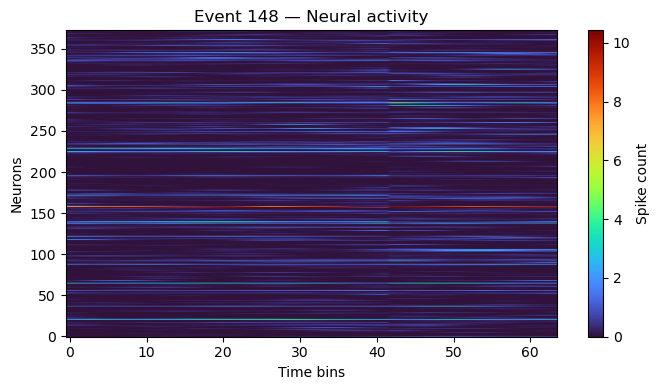

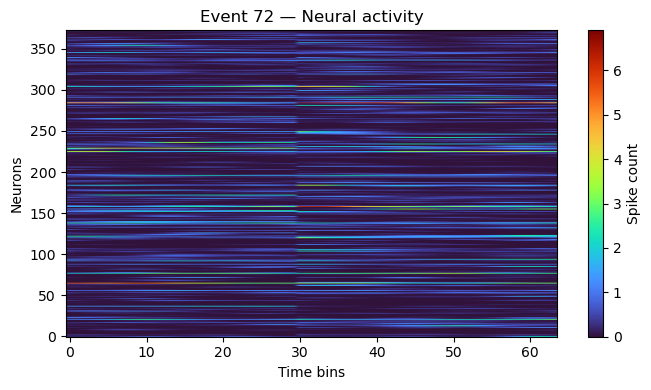

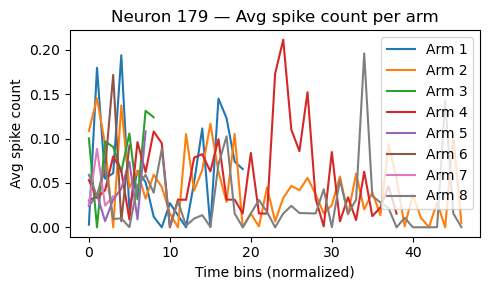

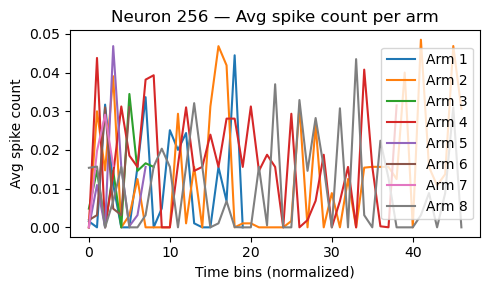

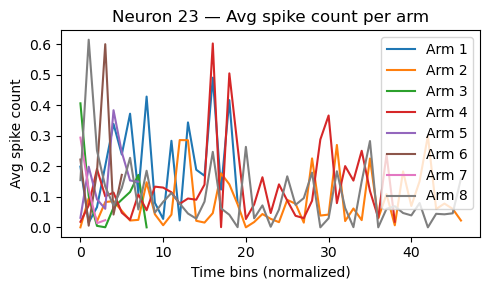

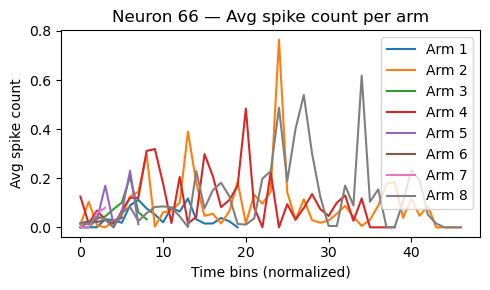

In [81]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_events(tensor, n_events=3):
    """
    Plotea la matriz neuronas × time bins de eventos aleatorios.

    Parameters:
    - tensor: np.ndarray of shape (neurons, time_bins, events)
    - n_events: int, cuántos eventos plotear
    """
    if tensor is None:
        print("Tensor is None.")
        return

    n_neurons, n_bins, n_total_events = tensor.shape
    event_indices = np.random.choice(n_total_events, size=n_events, replace=False)

    for i, idx in enumerate(event_indices):
        plt.figure(figsize=(7, 4))
        plt.imshow(tensor[:, :, idx], aspect='auto', origin='lower', cmap='turbo')
        plt.colorbar(label='Spike count')
        plt.xlabel('Time bins')
        plt.ylabel('Neurons')
        plt.title(f'Event {idx} — Neural activity')
        plt.tight_layout()
        plt.show()


def plot_avg_spikecount_by_arm(tensor, arm_ids, neuron_indices=None, max_neurons=4):
    """
    Plotea el spike count promedio por time bin para cada tipo de evento (arm),
    pero usando solo los eventos que tienen datos válidos en cada bin.

    Esto evita sesgo al final del tiempo por interpolación forzada en eventos más cortos.
    """
    if tensor is None:
        print("Tensor is None.")
        return

    n_neurons, n_bins, n_events = tensor.shape
    unique_arms = sorted(set(arm_ids))
    colors = plt.cm.tab10.colors  # hasta 10 colores

    if neuron_indices is None:
        neuron_indices = np.random.choice(n_neurons, size=min(max_neurons, n_neurons), replace=False)

    for neuron in neuron_indices:
        plt.figure(figsize=(5, 3))
        for i, arm in enumerate(unique_arms):
            indices = [j for j, aid in enumerate(arm_ids) if aid == arm]
            if not indices:
                continue

            neuron_data = tensor[neuron, :, indices]  # shape: (time_bins, n_events_for_this_arm)
            valid_mask = ~np.isnan(neuron_data)  # (time_bins, n_events)
            with np.errstate(invalid='ignore'):
                avg_curve = np.nanmean(neuron_data, axis=1)
                std_curve = np.nanstd(neuron_data, axis=1)

            plt.plot(avg_curve, label=f'Arm {arm}', color=colors[i % len(colors)])
            # Optional: add shaded area for variability
            # plt.fill_between(range(n_bins), avg_curve - std_curve, avg_curve + std_curve,
            #                  color=colors[i % len(colors)], alpha=0.2)

        plt.title(f'Neuron {neuron} — Avg spike count per arm')
        plt.xlabel('Time bins (normalized)')
        plt.ylabel('Avg spike count')
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_random_events(tensorTE_filt_100pp, n_events=2)
plot_avg_spikecount_by_arm(tensorTE_filt_100pp, kept_arms)

In [67]:
def select_rewarded_arms(tensor, event_arm_ids,reward_arms, dim_events):

    import numpy as np
    
    event_arm_ids = np.array(event_arm_ids)
    reward_arms = np.array(reward_arms)
    
    # Creamos una máscara booleana: True si el evento pertenece a un brazo premiado
    mask_rewarded = np.isin(event_arm_ids, reward_arms)
    
    # Aplicamos la máscara al tensor y a los Arm IDs
    if dim_events==1:
        tensor_rewarded = tensor[:, mask_rewarded, :]

    if dim_events==2:
        tensor_rewarded = tensor[:, :, mask_rewarded]
    
    event_arm_ids_rewarded = event_arm_ids[mask_rewarded]
    
    print(f"Total number of events: {len(event_arm_ids)}")
    print(f"Number of events in reward arms: {len(event_arm_ids_rewarded)}")
    
    print(tensor_rewarded.shape)
    
    return tensor_rewarded, event_arm_ids_rewarded

In [68]:
tensorTE_filt_100pp_rewarded, pfc_rewarded_arms = select_rewarded_arms(tensorTE_filt_100pp, event_arm_ids, reward_arms, 2)
tensorTE_filt_100hp_rewarded, hpc_rewarded_arms = select_rewarded_arms(tensorTE_filt_100hp, event_arm_ids, reward_arms, 2)

Total number of events: 180
Number of events in reward arms: 133
(373, 64, 133)
Total number of events: 180
Number of events in reward arms: 133
(40, 64, 133)


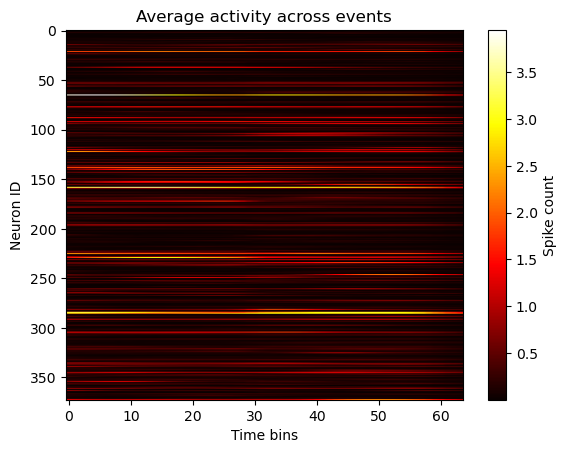

In [83]:
mean_activity = tensorTE_filt_100pp.mean(axis=2)  # average over events

plt.imshow(mean_activity, aspect='auto', cmap='hot')
plt.title("Average activity across events")
plt.xlabel("Time bins")
plt.ylabel("Neuron ID")
plt.colorbar(label="Spike count")
plt.show()

Text(0.5, 1.0, 'Temporal distribution of arm visits')

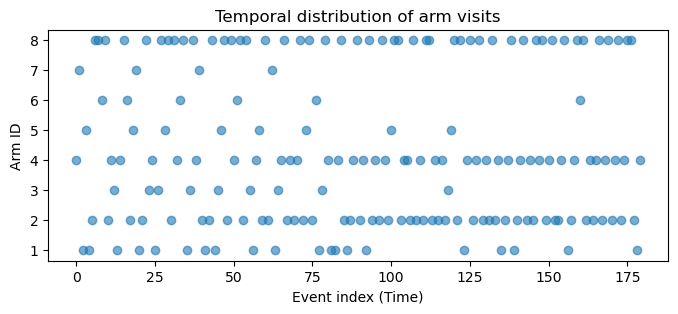

In [82]:
# Check temporal distribution of arms
plt.figure(figsize=(8, 3))
plt.scatter(range(len(event_arm_ids)), event_arm_ids, alpha=0.6)
plt.xlabel('Event index (Time)')
plt.ylabel('Arm ID')
plt.title('Temporal distribution of arm visits')
# Look for temporal clustering by arm

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Helpers
def _arm_colors(arm_ids):
    """Map each arm id to a distinct color and return an array of per-event colors."""
    arm_ids = np.asarray(arm_ids).astype(int)
    uniq = np.unique(arm_ids)
    cmap = plt.get_cmap("tab10")
    arm2color = {a: cmap(i % 10) for i, a in enumerate(uniq)}
    colors = np.array([arm2color[a] for a in arm_ids])
    return colors, arm2color

def _sem(a, axis=0):
    """Numerically safe standard error of the mean."""
    a = np.asarray(a, float)
    n = np.sum(~np.isnan(a), axis=axis)
    s = np.nanstd(a, axis=axis, ddof=1)
    with np.errstate(divide="ignore", invalid="ignore"):
        out = s / np.sqrt(np.maximum(n, 1))
    return np.where(n > 1, out, np.nan)


def build_event_position_tensor(activity_matrix, lwhl, event_intervals_ms, arm_ids,
                                bin_size_ms=100, sampling_rate_wheel=39.0625, speed=None, speed_threshold=5, verify=False, verify_opts=None):  
    """
    Build a 3D tensor (neurons × events × 140 position bins).

    Returns
    -------
    tensor : np.ndarray
        (N × E × 140)
    event_labels : np.ndarray
        (E,)
    stats : dict
        includes 'counts_per_pos' (E × 140)

    Notes (QC)
    ----------
    - If `verify=True`, at the end we show:
      (1) For a chosen neuron, per-event totals (sum over position), colored by arm, with per-arm mean±SEM bars.
      (2) Per-arm position profiles (mean over events of that arm), to check tuning consistency across arms.
    """
    n_neurons, n_bins_total = activity_matrix.shape
    n_events = len(event_intervals_ms)

    bin_times_ms = np.arange(n_bins_total) * bin_size_ms + bin_size_ms / 2

    ms_per_sample = 1000 / sampling_rate_wheel
    sample_times = lwhl.index.values * ms_per_sample
    pos_values = lwhl["linearized_pos_long"].values

    closest_idx = np.searchsorted(sample_times, bin_times_ms)
    closest_idx = np.clip(closest_idx, 0, len(lwhl) - 1)

    # === Speed filtering ===
    if speed is not None:
        speed_mask = speed[closest_idx] >= speed_threshold
        valid_bins = np.where(speed_mask)[0]

        activity_matrix = activity_matrix[:, valid_bins]
        bin_times_ms = bin_times_ms[valid_bins]
        closest_idx = closest_idx[valid_bins]
        bin_positions = pos_values[closest_idx]
    else:
        bin_positions = pos_values[closest_idx]

    pos_bins = np.clip(np.round(bin_positions).astype(int), 0, 139)

    tensor = np.zeros((n_neurons, n_events, 140), dtype=np.float32)
    counts_per_pos = np.zeros((n_events, 140), dtype=int)

    for e_idx, (start_ms, end_ms) in enumerate(event_intervals_ms):
        mask = (bin_times_ms >= start_ms) & (bin_times_ms < end_ms)
        event_bins = np.where(mask)[0]

        if len(event_bins) == 0:
            continue

        for pos in range(140):
            bins_at_pos = event_bins[pos_bins[event_bins] == pos]
            if len(bins_at_pos) > 0:
                tensor[:, e_idx, pos] = activity_matrix[:, bins_at_pos].mean(axis=1)
                counts_per_pos[e_idx, pos] = len(bins_at_pos)

    event_labels = np.array(arm_ids)

    # === plots ===
    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(140), counts_per_pos.sum(axis=0))
    plt.xlabel("Position bin (cm)")
    plt.ylabel("Total # time bins across events")
    plt.title("Distribution of time bins per position")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(9, 8))
    cmap = plt.get_cmap("viridis", 140)
    sc = plt.scatter(lwhl["x1"], lwhl["y1"],
                     c=np.clip(np.round(lwhl["linearized_pos_long"]).astype(int), 0, 139),
                     cmap=cmap, s=5)
    plt.colorbar(sc, label="Position bin (0–139)")
    plt.title("Trajectory colored by position bins")
    plt.xlabel("x1 (cm)")
    plt.ylabel("y1 (cm)")
    plt.tight_layout(); plt.show()

    example_neuron = np.random.randint(0, n_neurons)
    plt.figure(figsize=(10, 4))
    plt.imshow(tensor[example_neuron], aspect="auto", cmap="turbo")
    plt.colorbar(label="Mean spike count")
    plt.xlabel("Position bin (0–139)")
    plt.ylabel("Event index")
    plt.title(f"Neuron {example_neuron} activity (events × position)")
    plt.tight_layout(); plt.show()

    stats = {"counts_per_pos": counts_per_pos, "total_bins": activity_matrix.shape[1], "n_events": n_events}

    # QC / verification (optional)
    if verify:
        opts = verify_opts or {}
        neuron_idx = int(opts.get("neuron_idx", -1))
        if neuron_idx < 0 or neuron_idx >= tensor.shape[0]:
            # pick neuron with highest overall mean across E×P
            neuron_idx = int(np.argmax(tensor.mean(axis=(1, 2))))

        y = event_labels.astype(int)
        colors, arm2color = _arm_colors(y)

        # Per-event total for chosen neuron (sum across position bins)
        per_event_total = tensor[neuron_idx].sum(axis=1)  # (E,)
        plt.figure(figsize=(7, 4))
        plt.scatter(np.arange(per_event_total.size), per_event_total, c=colors, s=18)
        plt.title(f"Per-event total activity — Neuron {neuron_idx} (colored by arm)")
        plt.xlabel("Event"); plt.ylabel("Sum over position bins")
        plt.tight_layout(); plt.show()

        # Per-arm mean±SEM bars
        uniq = np.unique(y)
        means = []; sems = []
        for a in uniq:
            vals = per_event_total[y == a]
            means.append(np.mean(vals) if vals.size else np.nan)
            sems.append(_sem(vals))
        plt.figure(figsize=(6, 4))
        plt.bar(np.arange(len(uniq)), means, yerr=sems, capsize=3)
        plt.xticks(np.arange(len(uniq)), [str(a) for a in uniq])
        plt.title("Per-arm mean±SEM (per-event totals)")
        plt.xlabel("Arm ID"); plt.ylabel("Total activity")
        plt.tight_layout(); plt.show()

    return tensor, event_labels, stats

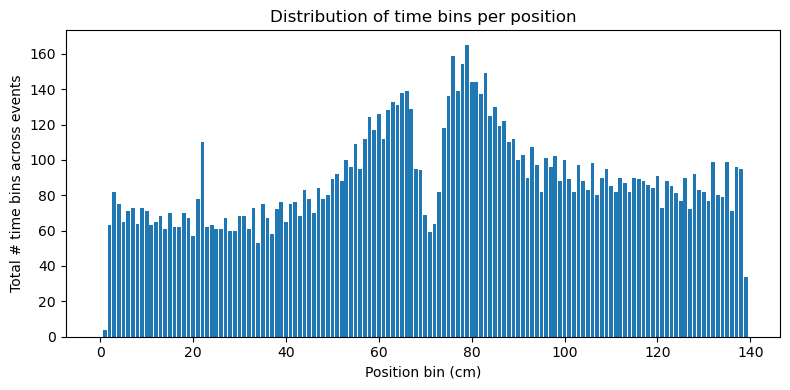

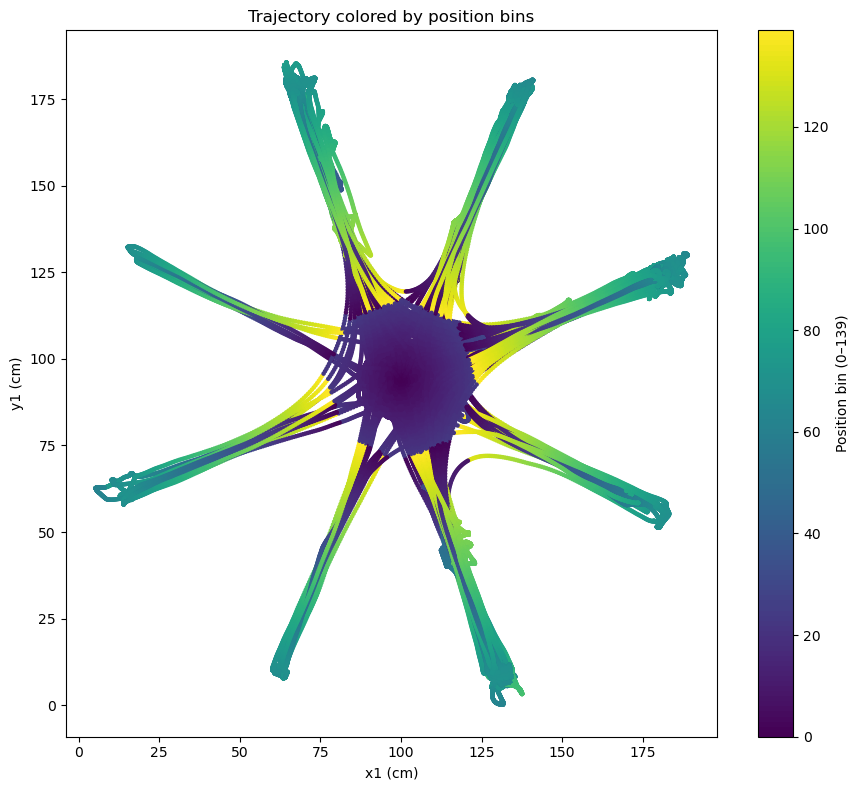

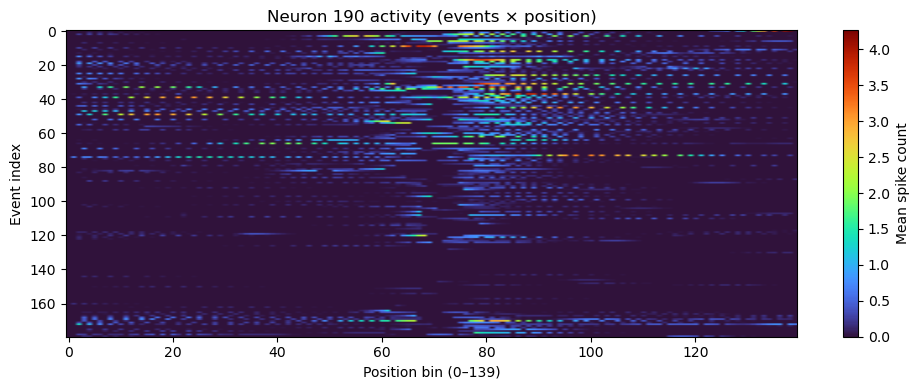

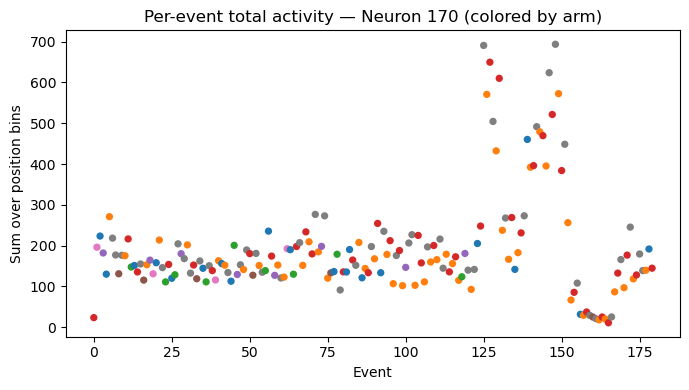

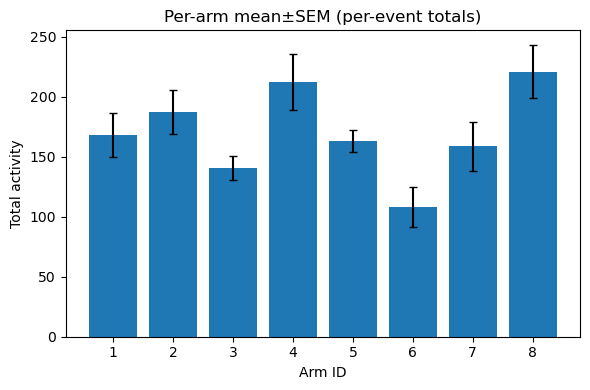

In [70]:
tensorNEP_all100pp, event_labels, stats = build_event_position_tensor(mat_100pp_spikefiltered, lwhl, event_intervals_ms, event_arm_ids,
                                bin_size_ms=100, sampling_rate_wheel=39.0625, speed=speed, speed_threshold=5, verify=True, verify_opts=None)

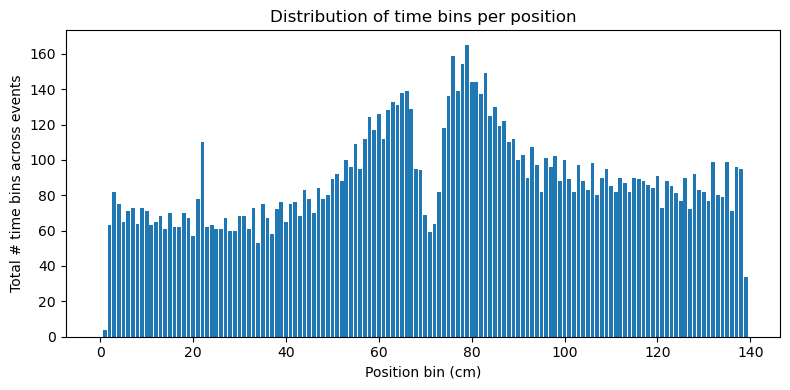

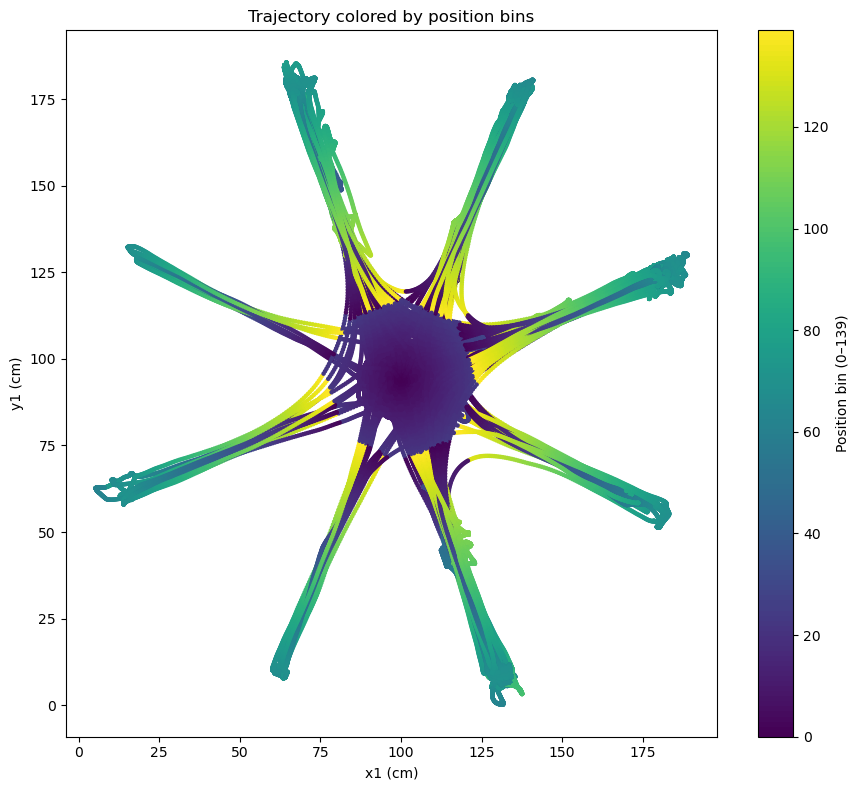

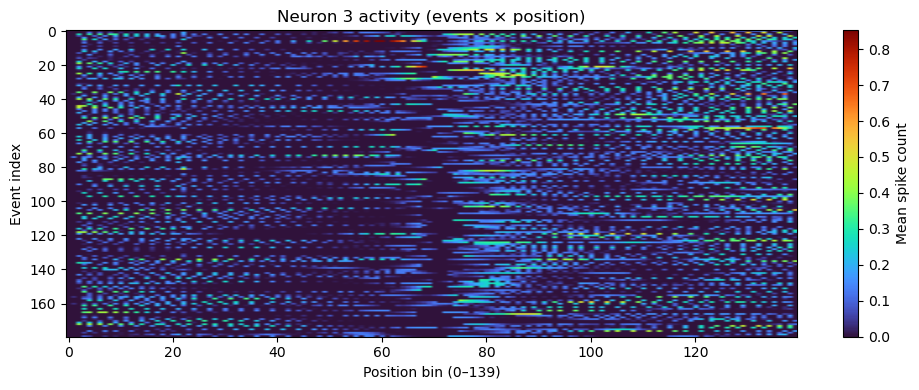

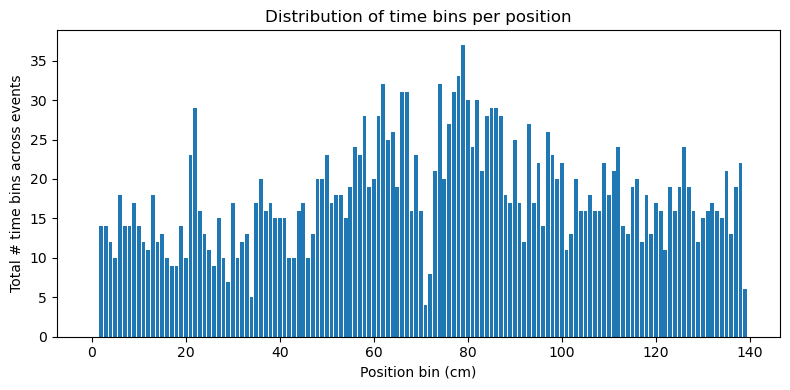

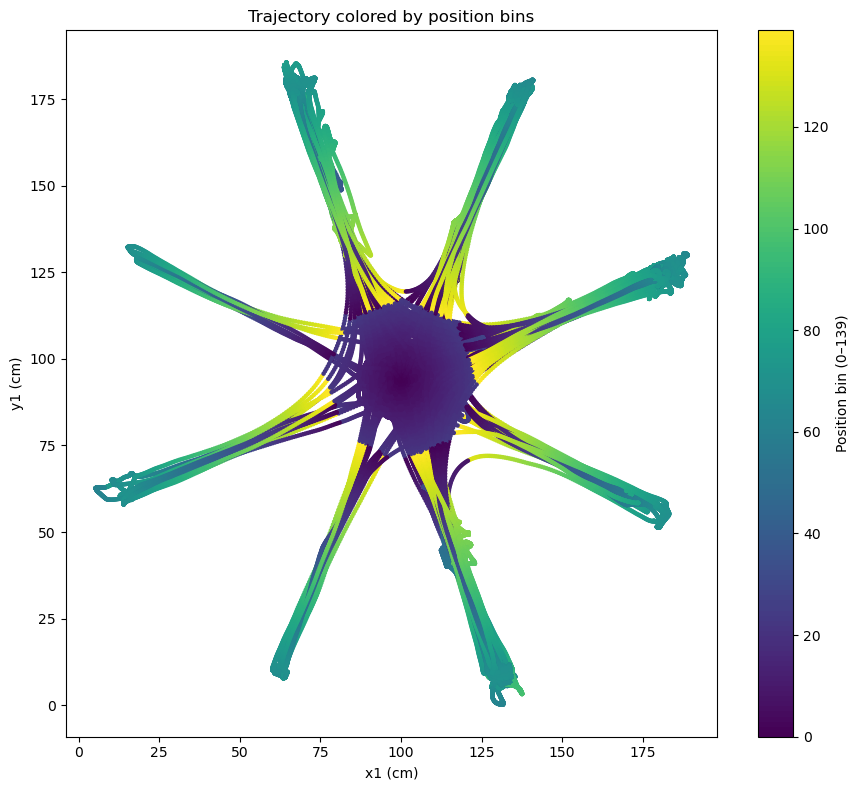

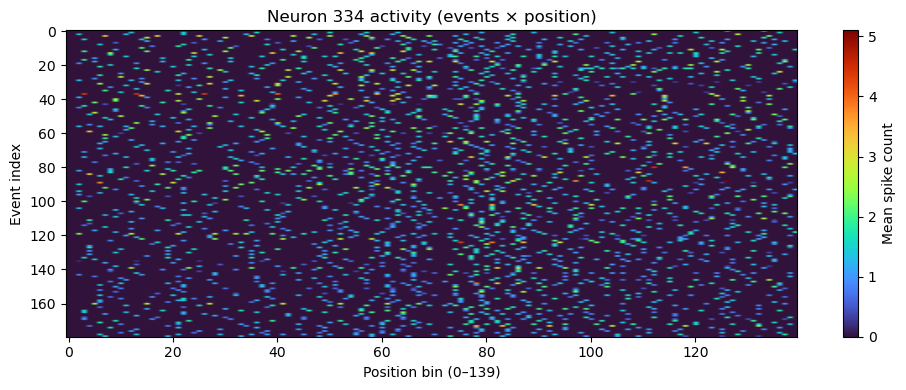

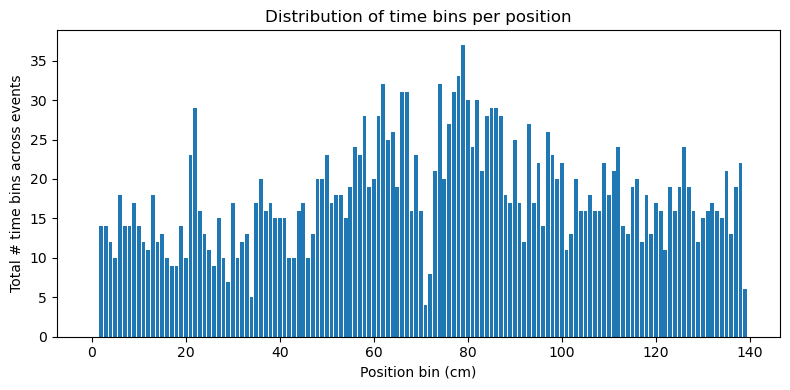

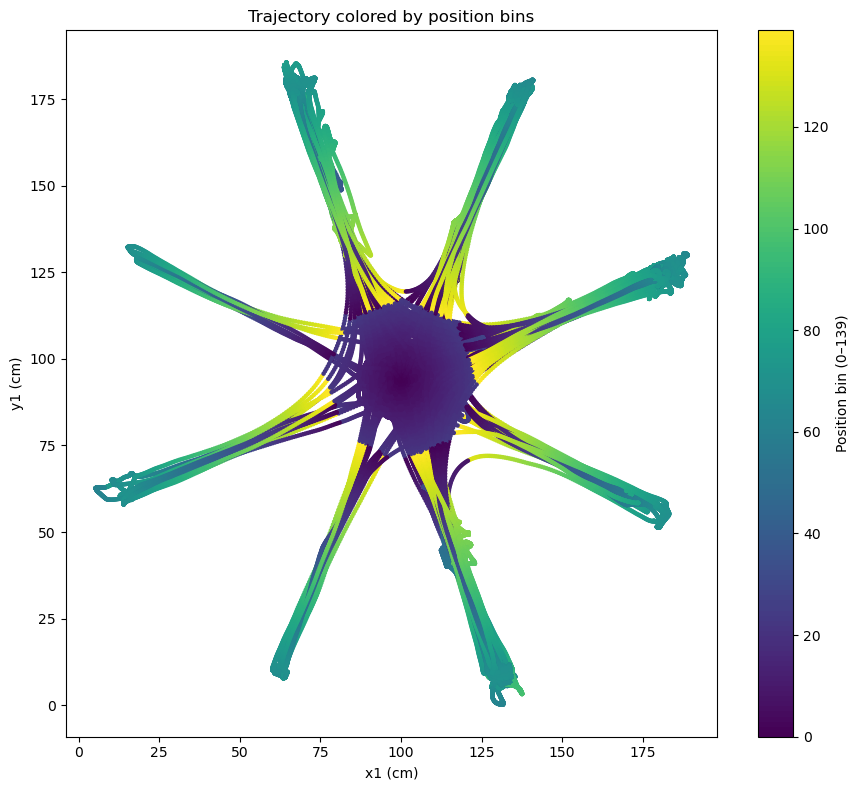

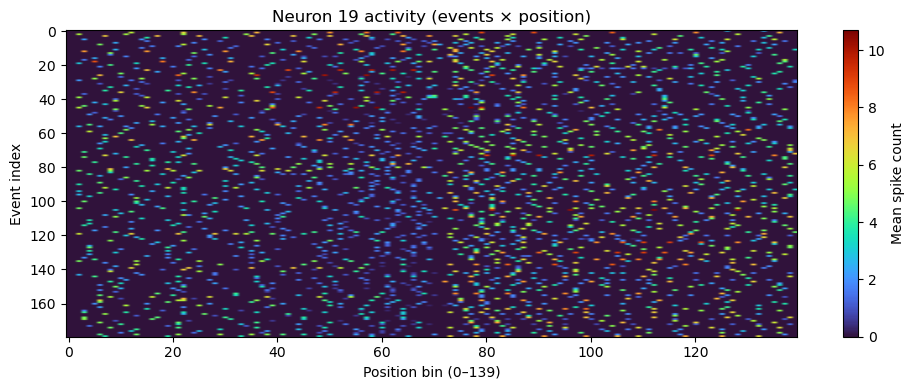

In [71]:
tensorNEP_all100hp, event_labels, stats = build_event_position_tensor(mat_100hp_spikefiltered, lwhl, event_intervals_ms, event_arm_ids,
                                bin_size_ms=100, sampling_rate_wheel=39.0625, speed=speed, speed_threshold=5, verify=False, verify_opts=None)

tensorNEP_all500pp, event_labels, stats = build_event_position_tensor(mat_500pp_spikefiltered, lwhl, event_intervals_ms, event_arm_ids,
                                bin_size_ms=500, sampling_rate_wheel=39.0625, speed=speed, speed_threshold=5, verify=False, verify_opts=None)

tensorNEP_all500hp, event_labels, stats = build_event_position_tensor(mat_500hp_spikefiltered, lwhl, event_intervals_ms, event_arm_ids,
                                bin_size_ms=500, sampling_rate_wheel=39.0625, speed=speed, speed_threshold=5, verify=False, verify_opts=None)

In [74]:
tensorNEP_rewarded100pp, event_arm_ids_rewarded = select_rewarded_arms(tensorNEP_all100pp, event_arm_ids,reward_arms, 1)
tensorNEP_rewarded100hp, event_arm_ids_rewarded = select_rewarded_arms(tensorNEP_all100hp, event_arm_ids,reward_arms, 1)
tensorNEP_rewarded500pp, event_arm_ids_rewarded = select_rewarded_arms(tensorNEP_all500pp, event_arm_ids,reward_arms, 1)
tensorNEP_rewarded500hp, event_arm_ids_rewarded = select_rewarded_arms(tensorNEP_all500hp, event_arm_ids,reward_arms, 1)

Total number of events: 180
Number of events in reward arms: 133
(399, 133, 140)
Total number of events: 180
Number of events in reward arms: 133
(40, 133, 140)
Total number of events: 180
Number of events in reward arms: 133
(399, 133, 140)
Total number of events: 180
Number of events in reward arms: 133
(40, 133, 140)


In [78]:
import pickle

with open("tensors.pkl", "wb") as f:
    pickle.dump({
        "tensorNEP_rewarded100pp": tensorNEP_rewarded100pp,
        "tensorNEP_rewarded500pp": tensorNEP_rewarded500pp,
        "tensorNEP_rewarded100hp": tensorNEP_rewarded100hp,
        "tensorNEP_rewarded500hp": tensorNEP_rewarded500hp,
        "tensorNEP_all100pp": tensorNEP_all100pp,
        "tensorNEP_all500pp": tensorNEP_all500pp,
        "tensorNEP_all100hp": tensorNEP_all100hp,
        "tensorNEP_all500hp": tensorNEP_all500hp,
        "tensorTE_filt_100pp": tensorTE_filt_100pp,
        "tensorTE_filt_500pp": tensorTE_filt_500pp,
        "tensorTE_filt_100hp": tensorTE_filt_100hp,
        "tensorTE_filt_500hp": tensorTE_filt_500hp,
        "tensorTE_filt_100pp_rewarded": tensorTE_filt_100pp_rewarded,
        "tensorTE_filt_100hp_rewarded": tensorTE_filt_100hp_rewarded,
        "reward_arms": reward_arms,
        "speed": speed,
        "lwhl": lwhl,
        "event_intervals_ms": event_intervals_ms,
        "mat_100pp_spikefiltered": mat_100pp_spikefiltered, 
        "mat_100hp_spikefiltered": mat_100hp_spikefiltered, 
        "event_arm_ids_rewarded": event_arm_ids_rewarded,
        "event_arm_ids": event_arm_ids,}, f)

print("Saved as tensors.pkl")

Saved as tensors.pkl


In [85]:
with open("qnn_data.pkl", "wb") as f:
        pickle.dump({
            "tensor_pfc_all": tensorTE_filt_100pp,
            "tensor_hpc_all": tensorTE_filt_100hp,
            "tensor_pfc_rewarded": tensorTE_filt_100pp_rewarded,
            "tensor_hpc_rewarded": tensorTE_filt_100hp_rewarded,
            "event_arm_ids_all": event_arm_ids,
            "event_arm_ids_rewarded": event_arm_ids_rewarded,
            "trial_ids_all": trial_ids_all,
            "trial_ids_rewarded": trial_ids_rewarded}, f)
    
print("Saved as qnn_data.pkl")

Saved as qnn_data.pkl
